In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import math
import random

if torch.cuda.is_available():
  dev = 'cuda'
  print("Cuda avaiable. Device used to train the model:", dev)
else: 
  dev = 'cpu'
  print("Cuda not avaiable. Device used to train the model:", dev)


Cuda avaiable. Device used to train the model: cuda


/disks/disk1/giudiciga/miniconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **A harmonic series dataset**

This dataset generates a periodic wave given a harmonic distribution and a number of cycles we want to compute.

In [2]:
# First version of HarmonicSeriesDataset (from: sequential_things.ipynb by Franco Caspe)
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(n_freqs)
        self.freqs = torch.linspace(start=0, end=n_freqs-1, steps=n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = 0
        self.phases += 2*np.pi*self.freqs/self.sample_rate
        sample = torch.sum(self.harmonics*torch.sin(self.phases))
        return sample

In [3]:
# Second version of HarmonicSeriesDataset
class HarmonicSeriesDataset(Dataset):
    
    def __init__(self, harmonics,n_periods=1):
        self.harmonics = torch.tensor(harmonics)
        self.len = n_periods*2*harmonics.size()[0]
        self.sample_rate = 2*harmonics.size()[0]
        self.n_freqs = harmonics.size()[0]
        self.phases = torch.zeros(self.n_freqs)
        self.freqs = torch.linspace(start=0, end=self.n_freqs-1, steps=self.n_freqs)
    
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
      self.phases[:] = 0
      check = np.random.choice([True,False])
      input = torch.ones(self.len) if(check) else torch.zeros(self.len)
      # delay = np.random.randint(0,self.len-2)
      d_1 = np.random.randint(0,self.len/2)
      d_2 = np.random.randint(self.len/2,self.len-2)
      input[d_1:d_2] = 0 if(check) else 1
      #input[0:delay] = 0
      output = torch.zeros(self.len)
      
      for i in range(self.len):   
        self.phases += (2*np.pi*self.freqs/self.sample_rate)
        self.phases = self.phases * input[i]
        output[i] = torch.sum(self.harmonics*torch.sin(self.phases))*input[i]    
      return input, output

# Dataset
Let's generate a dataset and plot its content.

/tmp/ipykernel_13102/1884922213.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.harmonics = torch.tensor(harmonics)


240
240
Samples.shape: torch.Size([128, 240, 2])


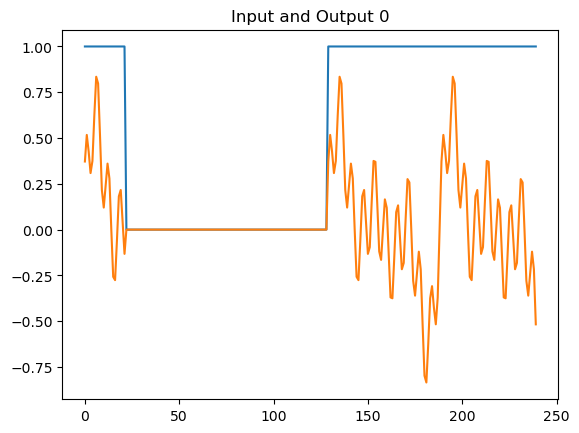

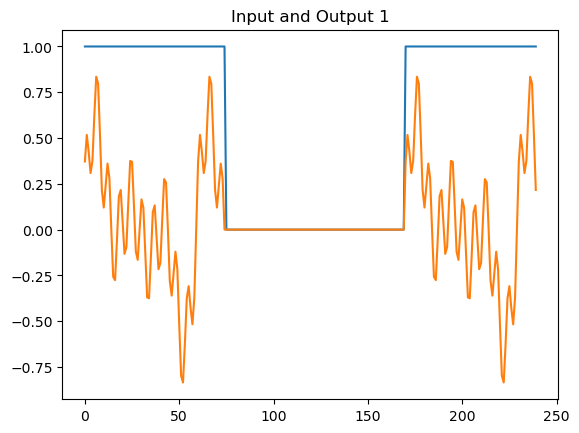

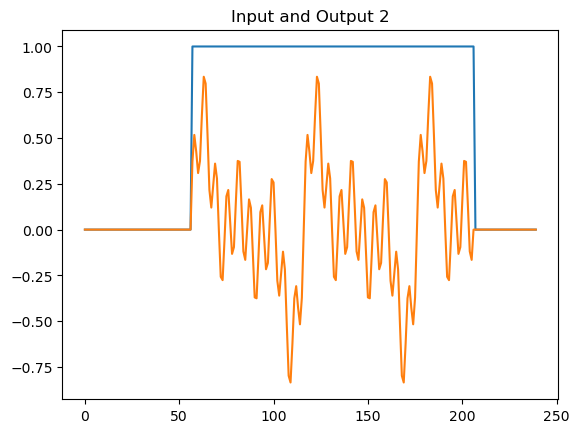

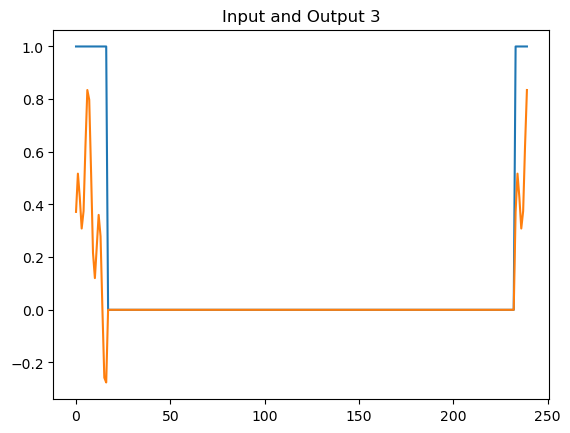

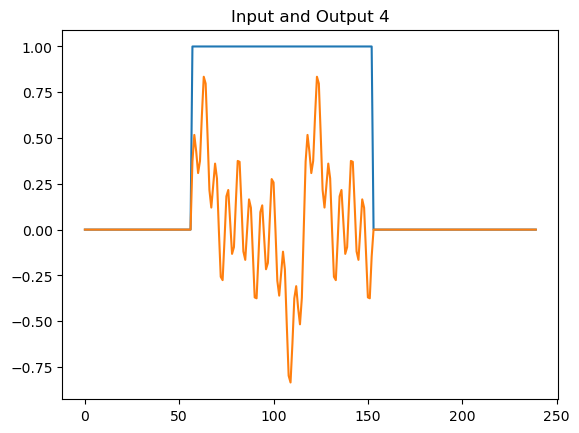

In [6]:
# Dataset configuration
period_len = 60
n_periods = 4
# Generate a distribution of harmonics
harmonics = torch.zeros(period_len//2)
harmonics[1] = 1
harmonics[2] = 1
harmonics[3] = 1
harmonics[10] = 1
# Normalize distribution
harmonics = harmonics/torch.sum(harmonics)

# Create dataset
batch_size = 128
dataset = HarmonicSeriesDataset(harmonics,n_periods)
train_dataloader = torch.utils.data.DataLoader(dataset)

# Sample storage to plot
signal_len = len(train_dataloader)
print(period_len*n_periods)
print(signal_len)

train_samples = torch.zeros(batch_size,signal_len,2)

#for i,sample in enumerate(dataloader):
#      samples[:,i] = sample

for i in range(batch_size):
  train_samples[i,:,0],train_samples[i,:,1] = next(iter(train_dataloader))

print("Samples.shape:",train_samples.shape)
for i in range(5):
  plt.plot(train_samples[i,:,0].detach().numpy())
  plt.plot(train_samples[i,:,1].detach().numpy())
  plt.title("Input and Output {}".format(i))
  plt.show()


# **Gated Recurrent Unit (GRU)**

In [7]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, num_layers=1):
    super(GRUmodel, self).__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    # GRU (input)
    self.gru = nn.GRU(input_size, hidden_dim, num_layers=num_layers, batch_first=True)
    # Fully connected (output)
    self.lin = nn.Linear(hidden_dim, output_size)
    
  # Forward method
  def forward(self, seq):

    input = seq  # input.shape = (N,L,input_size)
    
    out, hidden = self.gru(input) # out.shape = (L,hidden_dim)...hidden.shape = (num_layers, hidden_dim)
    out = self.lin(out) # out.shape = (1,1)
    return out


In [8]:
def gru_evaluate_on_data(net, eval_input, target, device, plot=False):

  L = target.shape[1] # sequence length
  batch_size = target.shape[0] # batch size
  random = np.random.randint(0,batch_size-2)
  target = target[random,:,:].unsqueeze(0).to(device) # ([N,L,1])
  # seq = torch.ones([batch_size,L,1]).to(device) # ([N,L,1])
  seq = eval_input[random,:,:].unsqueeze(0).to(device)

  with torch.no_grad():
    pred = net(seq)
      # Calculate evaluation loss
  eval_loss = torch.sum(torch.abs(target-pred))

  # Plotting results
  if(plot):
    fig, ax = plt.subplots()
    print("[TEST ON DATA] Eval loss {}".format(eval_loss))
    ax.plot(seq[0,:,:].detach().cpu().numpy())
    ax.plot(target[0,:,:].detach().cpu().numpy())
    ax.plot(pred[0,:,:].detach().cpu().numpy())
    plt.show()

  return eval_loss
  
def gru_train(net, epochs, train_samples, device):
  
  net.train()

  # Define Loss, Optimizer, ecc.
  criterion = nn.L1Loss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  best_eval_loss = np.inf

  target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  train = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1]) 
  L = target.shape[1] # sequence length
  n_batches = target.shape[0] # batch size
  epochs_loss = np.zeros(epochs)

  for epoch in range(epochs): 
    optimizer.zero_grad()
    running_loss = 0.0
    # seq = torch.ones([n_batches,L,1]).to(device) # ([N,L,1])
    seq = train_samples[:,:,0].unsqueeze(2).to(device)
    prediction = net(seq)
    loss = criterion(prediction, target) # Calculate loss
    loss.backward() # Backpropagation and calculates gradients
    optimizer.step() # Updates the weights
    # Print statistics
    running_loss += loss.item() # To calculate epochs' mean loss
    plot = True if (epoch%(epochs/16)==0) else False
    eval_loss = gru_evaluate_on_data(net, seq, target, device, plot=plot)
    
    epochs_loss[epoch] = eval_loss # For plotting loss during epochs

    if eval_loss < best_eval_loss:
      best_eval_loss = eval_loss
      torch.save(net.state_dict(), 'best_gru.pt')

    if (epoch%(epochs/20) == 0):
        print('Epoch: {}/{} .............'.format(epoch, epochs), end=' ')
        print("Train Loss: {:.4f} - Best Eval {:.4f}".format(running_loss, best_eval_loss))
    
    running_loss = 0.0

  print("---------- FINISHED TRAINING ----------")

  # Print Eval Loss
  x_ = np.linspace(0, epochs-1, epochs)
  y_ = epochs_loss
  yhat_ = signal.savgol_filter(y_, 101, 3) # Savitzky-Golay filter for smoothing

  fig, ax = plt.subplots()
  ax.plot(x_, y_)
  ax.plot(x_, yhat_)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Eval Loss') 
  # ax.grid(True) 
  plt.show()

In [12]:
def train_and_test_GRU(hidden_size, n_hidden_layers, train_data, target, epochs, device):
  train_len = train_data.size()[2]

  net = GRUmodel(1,1,hidden_size, n_hidden_layers)
  net = net.to(device)

  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("[INFO] Number of parameters: {}".format(params))
  
  # TRAINING
  gru_train(net, epochs, train_data, device)

  # TEST
  net.load_state_dict(torch.load('best_gru.pt'))  
  net.eval()
  target = train_samples[:,:,1].unsqueeze(2).to(device) #([N,L,1])
  input = train_samples[:,:,0].unsqueeze(2).to(device)
  gru_evaluate_on_data(net, input, target, device, plot=True)

  return net

[INFO] Number of parameters: 12929
[TEST ON DATA] Eval loss 34.70402908325195


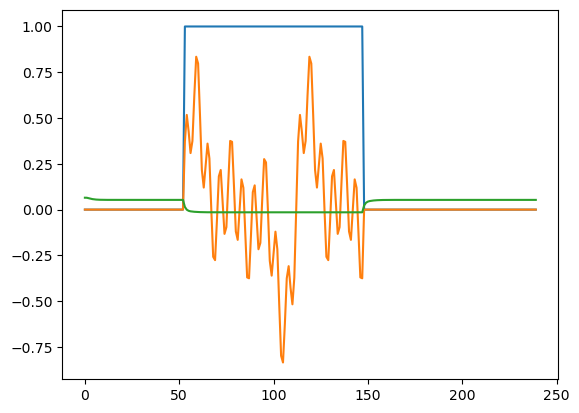

Epoch: 0/10000............. Train Loss: 0.1805 - Best Eval 34.7040
Epoch: 500/10000............. Train Loss: 0.1136 - Best Eval 3.2157
[TEST ON DATA] Eval loss 14.135669708251953


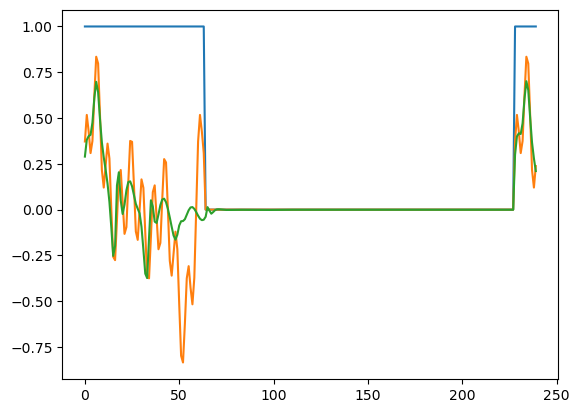

Epoch: 1000/10000............. Train Loss: 0.0633 - Best Eval 2.3928
[TEST ON DATA] Eval loss 10.547853469848633


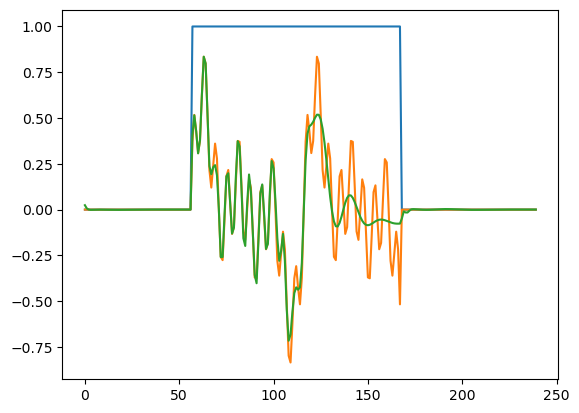

Epoch: 1500/10000............. Train Loss: 0.0670 - Best Eval 1.4945
[TEST ON DATA] Eval loss 18.23465347290039


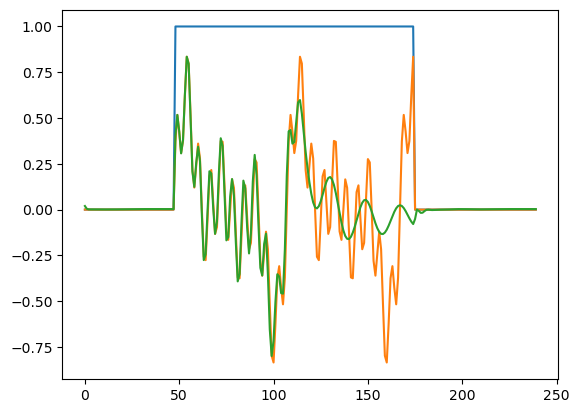

Epoch: 2000/10000............. Train Loss: 0.0456 - Best Eval 1.0733
[TEST ON DATA] Eval loss 10.1072998046875


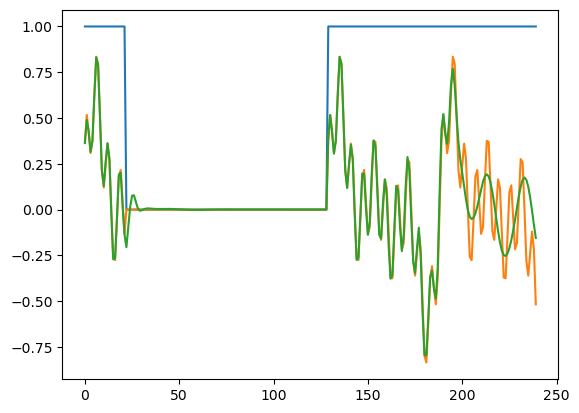

Epoch: 2500/10000............. Train Loss: 0.0475 - Best Eval 0.9952
Epoch: 3000/10000............. Train Loss: 0.0404 - Best Eval 0.7825
[TEST ON DATA] Eval loss 0.963200032711029


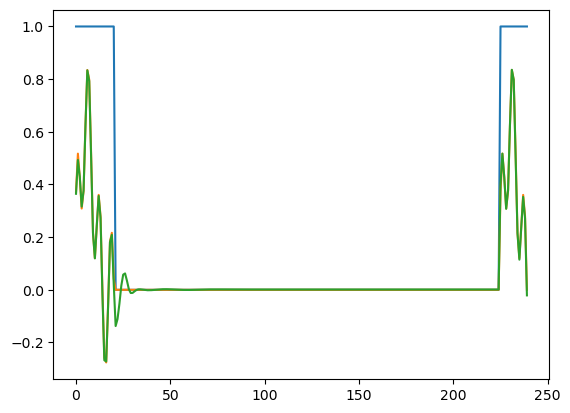

Epoch: 3500/10000............. Train Loss: 0.0385 - Best Eval 0.7470
[TEST ON DATA] Eval loss 7.826408863067627


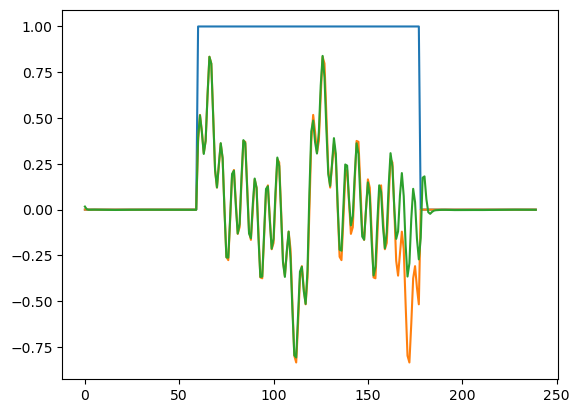

Epoch: 4000/10000............. Train Loss: 0.0323 - Best Eval 0.5781
[TEST ON DATA] Eval loss 3.4575586318969727


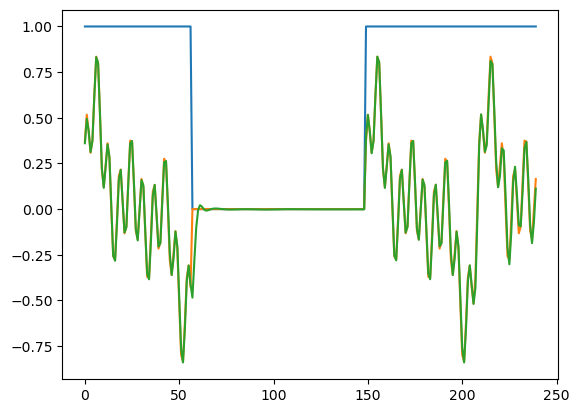

Epoch: 4500/10000............. Train Loss: 0.0255 - Best Eval 0.5781
[TEST ON DATA] Eval loss 5.969027042388916


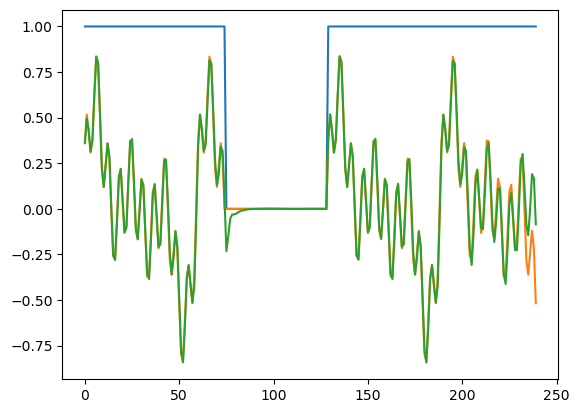

Epoch: 5000/10000............. Train Loss: 0.0295 - Best Eval 0.5781
Epoch: 5500/10000............. Train Loss: 0.0267 - Best Eval 0.5781
[TEST ON DATA] Eval loss 3.6699843406677246


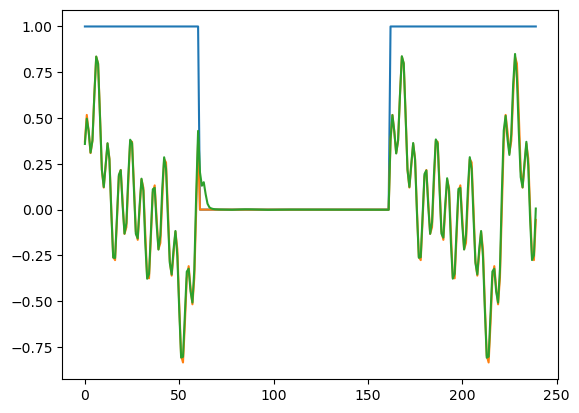

Epoch: 6000/10000............. Train Loss: 0.0323 - Best Eval 0.5335
[TEST ON DATA] Eval loss 7.380694389343262


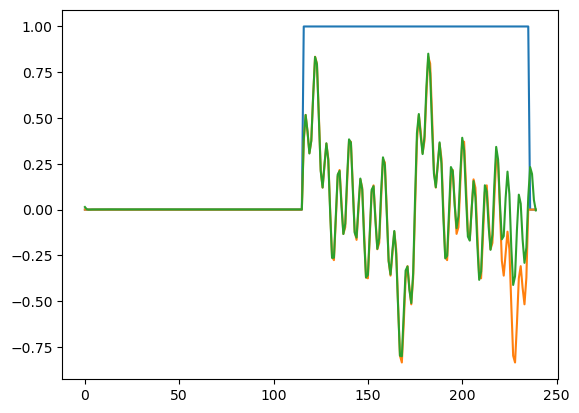

Epoch: 6500/10000............. Train Loss: 0.0260 - Best Eval 0.5335
[TEST ON DATA] Eval loss 1.4908026456832886


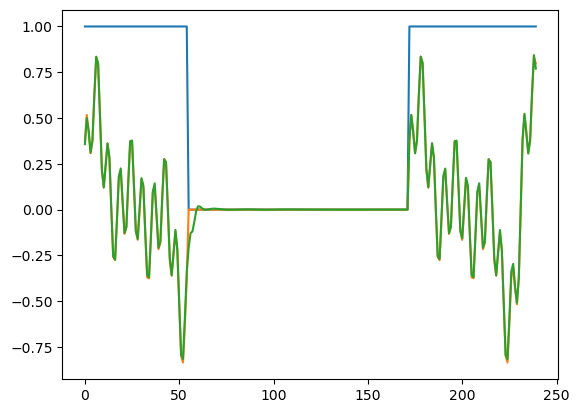

Epoch: 7000/10000............. Train Loss: 0.0249 - Best Eval 0.4994
[TEST ON DATA] Eval loss 2.5009689331054688


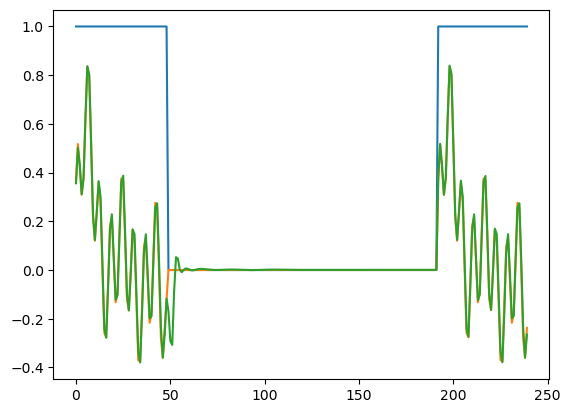

Epoch: 7500/10000............. Train Loss: 0.0247 - Best Eval 0.4994
Epoch: 8000/10000............. Train Loss: 0.0225 - Best Eval 0.4907
[TEST ON DATA] Eval loss 21.146591186523438


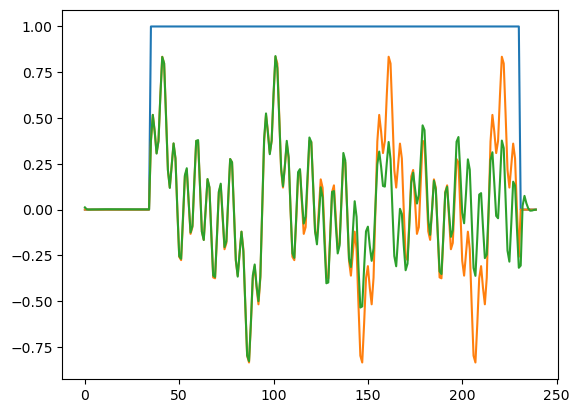

Epoch: 8500/10000............. Train Loss: 0.0116 - Best Eval 0.4383
[TEST ON DATA] Eval loss 1.7511498928070068


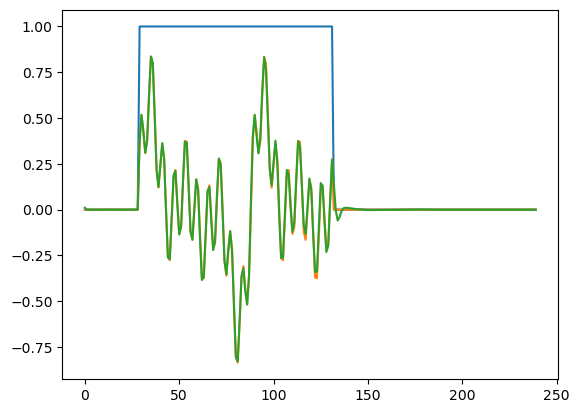

Epoch: 9000/10000............. Train Loss: 0.0084 - Best Eval 0.4383
[TEST ON DATA] Eval loss 1.696990966796875


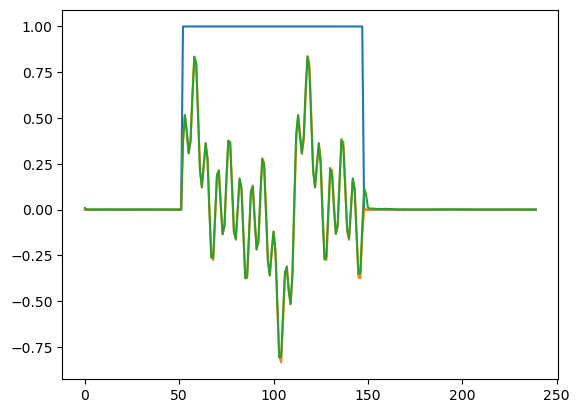

Epoch: 9500/10000............. Train Loss: 0.0064 - Best Eval 0.4023
---------- FINISHED TRAINING ----------


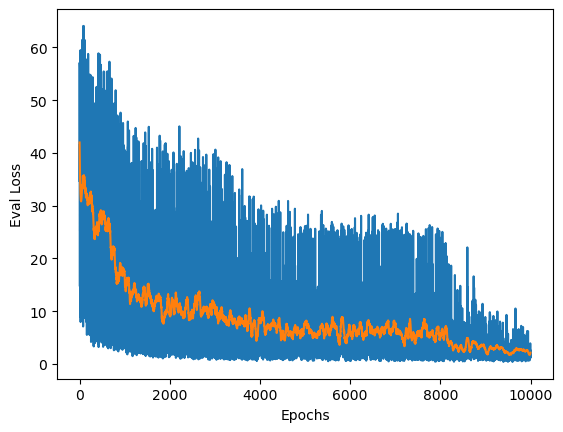

[TEST ON DATA] Eval loss 0.3998677432537079


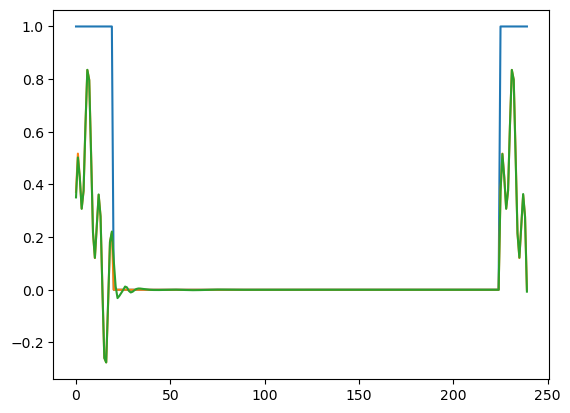

In [11]:
GRUnet = train_and_test_GRU(hidden_size=64, n_hidden_layers=1, train_data=train_samples, target=train_samples, epochs=10000, device=dev)

# **Testing Trained GRUnet**

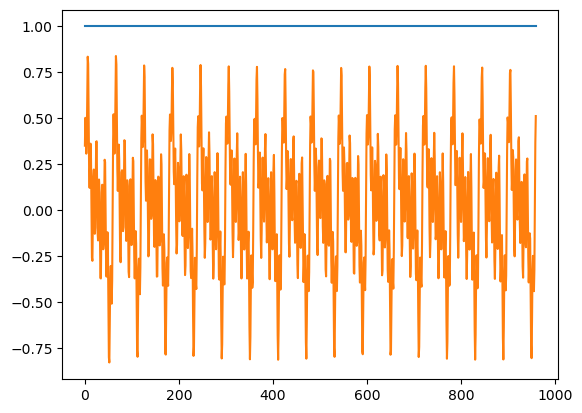

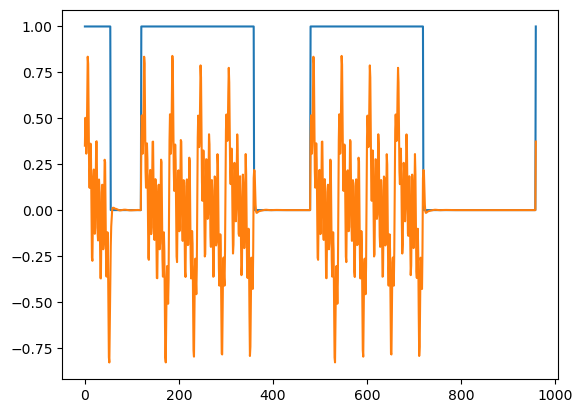

In [13]:
seq = torch.ones(1,960,1)
seq = seq.to(dev)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()

seq = torch.ones(1,960,1)
seq[:,55:120,:] = 0
seq[:,360:480,:] = 0
seq[:,720:959,:] = 0
seq = seq.to(dev)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()

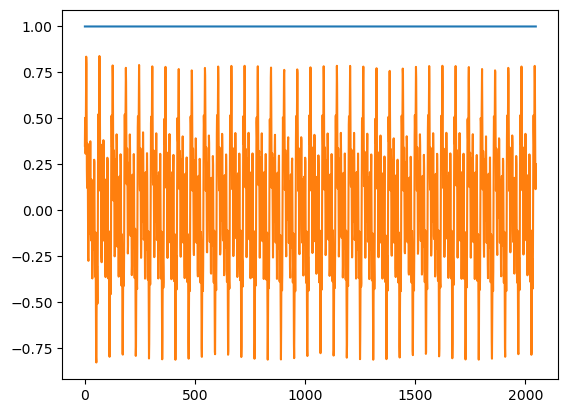

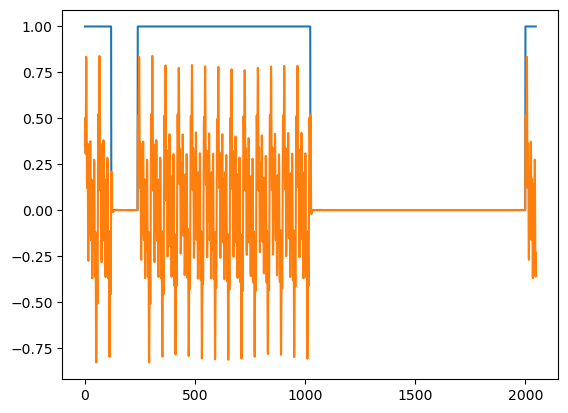

In [15]:
seq = torch.ones(1,2048,1)
seq = seq.to(dev)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()

seq = torch.ones(1,2048,1)
seq[:,120:240,:] = 0
seq[:,1024:2000,:] = 0
seq = seq.to(dev)
signal = GRUnet(seq)

plt.plot(seq[0,:,:].detach().cpu().numpy())
plt.plot(signal[0,:,:].detach().cpu().numpy())
plt.show()